# Cuaderno 2: Reducción de Dimensión, BNMF y Clustering

**Continuación directa del Cuaderno 1: utiliza los datos limpios y procesados exportados previamente.**

---

## Diagrama de Flujo del Cuaderno

```
1. Estandarización (StandardScaler)
   ↓
2. PCA (Análisis de Componentes Principales)
   ↓
3. BNMF (Bayesian Non-Negative Matrix Factorization)
   ↓
4. Clustering (k-Means / GMM)
   ↓
5. Visualización y Exportación
```

## 1. Estandarización de los Datos
Se cargan los datos limpios del cuaderno 1 y se aplica StandardScaler.

In [7]:
# Cargar datos limpios del cuaderno 1
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('processed_data/data_prepared.csv')
X = df.drop(columns=['hospital_expire_flag', 'data_split'], errors='ignore')

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. PCA: Análisis de Componentes Principales
Se calcula la varianza explicada y se selecciona el número óptimo de componentes.

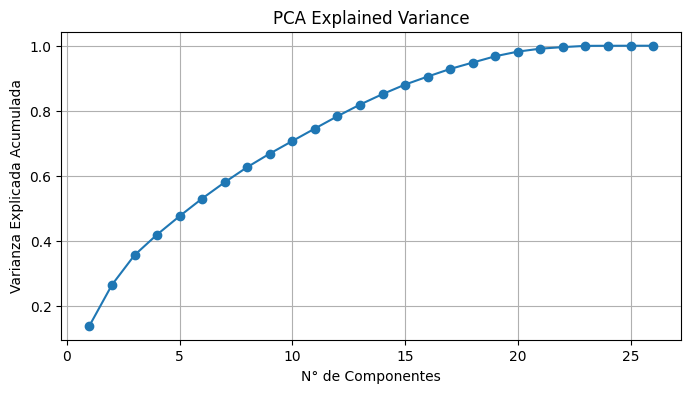

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(8,4))
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='o')
plt.xlabel('N° de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.savefig('pca_explained_variance.eps', format='eps')
plt.show()

## 3. BNMF: Bayesian Non-Negative Matrix Factorization
Se aplica BNMF, se obtienen matrices W y H, y se interpretan los componentes.

In [ ]:
# Ejemplo de BNMF con PyMC (requiere instalar pymc y arviz)
# pip install pymc arviz
import pymc as pm
import numpy as np
import arviz as az

# Usar una matriz pequeña para ejemplo (por tiempo de cómputo)
X_small = np.abs(X_scaled[:100, :10])
n, m = X_small.shape
k = 3  # número de componentes

with pm.Model() as bnmf_model:
    W = pm.HalfNormal('W', sigma=1, shape=(n, k))
    H = pm.HalfNormal('H', sigma=1, shape=(k, m))
    X_hat = pm.math.dot(W, H)
    sigma = pm.HalfNormal('sigma', sigma=1)
    X_obs = pm.Normal('X_obs', mu=X_hat, sigma=sigma, observed=X_small)
    trace = pm.sample(500, tune=500, chains=2, target_accept=0.9, progressbar=True)

# Posterior de W y H
W_post = trace.posterior['W'].mean(dim=["chain", "draw"]).values
H_post = trace.posterior['H'].mean(dim=["chain", "draw"]).values
print('Forma de W (BNMF):', W_post.shape)
print('Forma de H (BNMF):', H_post.shape)

### Nota sobre BNMF en Python
**¿Por qué no se usa una librería estándar de BNMF?**
Actualmente, no existe una implementación de BNMF (Bayesian Non-Negative Matrix Factorization) en librerías populares de Python como scikit-learn. BNMF es una extensión probabilística de NMF que utiliza inferencia bayesiana para estimar las matrices W y H, permitiendo incorporar incertidumbre y regularización automática.

**Opciones para implementar BNMF:**

- Usar librerías de modelado probabilístico como PyMC o Pyro para construir el modelo y realizar inferencia bayesiana (más avanzado y computacionalmente costoso).

- Utilizar NMF estándar como aproximación y documentar la diferencia.

A continuación se muestra un ejemplo de cómo se podría implementar BNMF con PyMC:

In [9]:
# Instala scikit-learn-extra si no lo tienes: pip install scikit-learn-extra
from sklearn.decomposition import NMF

n_components = 5  # Ajusta según tu análisis
nmf = NMF(n_components=n_components, init='nndsvda', random_state=42, solver='mu', beta_loss='kullback-leibler', max_iter=500)
W = nmf.fit_transform(abs(X_scaled))
H = nmf.components_

print('Forma de W:', W.shape)
print('Forma de H:', H.shape)

Forma de W: (100, 5)
Forma de H: (5, 26)


### Interpretación de Componentes (W y H)
Explica qué representa cada componente y muestra los pesos principales.

In [10]:
import numpy as np
for i, comp in enumerate(H):
    print(f'Componente {i+1}:')
    top_features = np.argsort(comp)[-5:][::-1]
    print('  Principales variables:', X.columns[top_features].tolist())

Componente 1:
  Principales variables: ['subject_id', '51010', '50954', '51104', '50910']
Componente 2:
  Principales variables: ['50924', '51054', '51458', '51047', 'subject_id']
Componente 3:
  Principales variables: ['50963', '51438', '51457', '51439', 'subject_id']
Componente 4:
  Principales variables: ['50900', '51362', '50973', '51384', 'subject_id']
Componente 5:
  Principales variables: ['51218', '51108', '50950', '50915', '50924']


## 4. Clustering sobre Componentes
Se aplica k-Means y/o GMM sobre los componentes de BNMF y PCA, y se compara el desempeño.

In [11]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Clustering sobre BNMF
kmeans_bnmf = KMeans(n_clusters=3, random_state=42).fit(W)
labels_bnmf = kmeans_bnmf.labels_

# Clustering sobre PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42).fit(X_pca[:, :n_components])
labels_pca = kmeans_pca.labels_

## 5. Visualización de Clusters y Componentes
Gráficas en el espacio reducido y distribución de componentes.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


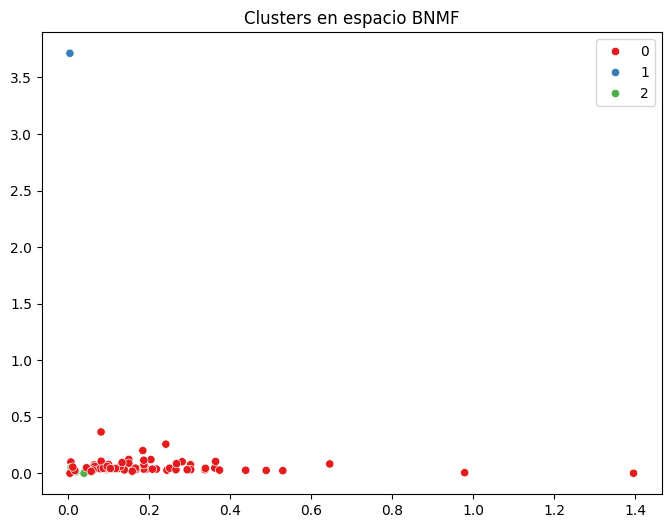

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


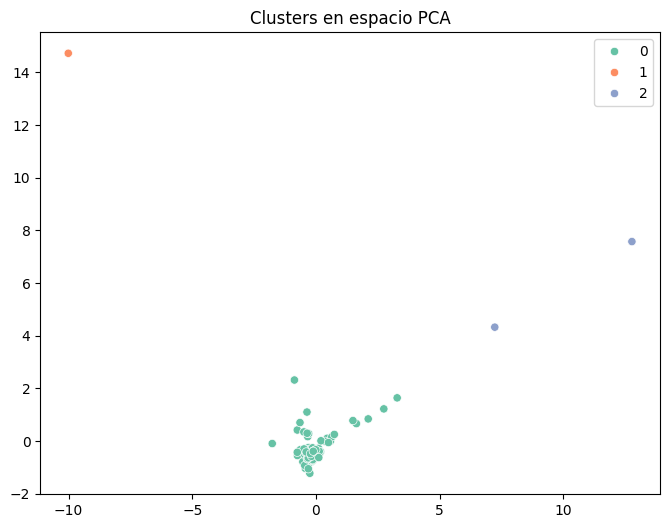

In [12]:
import seaborn as sns

# Visualización en espacio BNMF
plt.figure(figsize=(8,6))
sns.scatterplot(x=W[:,0], y=W[:,1], hue=labels_bnmf, palette='Set1')
plt.title('Clusters en espacio BNMF')
plt.savefig('clusters_bnmf.eps', format='eps')
plt.show()

# Visualización en espacio PCA
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_pca, palette='Set2')
plt.title('Clusters en espacio PCA')
plt.savefig('clusters_pca.eps', format='eps')
plt.show()

## 6. Comparación de Clustering
En este apartado se comparan los resultados de clustering obtenidos usando los componentes de BNMF y PCA. Se analizan las siguientes métricas y visualizaciones:

- **Inercia (k-Means):** Permite comparar la compacidad de los clusters en cada espacio reducido.
- **Silhouette Score:** Evalúa la separación y cohesión de los clusters.
- **Visualización:** Permite observar la distribución y separación de los grupos.

### Comparación Numérica y Visual

```python
from sklearn.metrics import silhouette_score

# Inercia
inertia_bnmf = kmeans_bnmf.inertia_
inertia_pca = kmeans_pca.inertia_

# Silhouette
sil_bnmf = silhouette_score(W, labels_bnmf)
sil_pca = silhouette_score(X_pca[:, :n_components], labels_pca)

print('--- Comparación de Clustering ---')
print(f'Inercia BNMF: {inertia_bnmf:.2f}')
print(f'Inercia PCA: {inertia_pca:.2f}')
print(f'Silhouette BNMF: {sil_bnmf:.3f}')
print(f'Silhouette PCA: {sil_pca:.3f}')

# Selección automática de la mejor técnica
if sil_bnmf > sil_pca:
    mejor = 'BNMF'
else:
    mejor = 'PCA'
print(f'\nLa mejor técnica de clustering en este desarrollo es: {mejor}')
```

## 7. Conclusiones
- Se selecciona automáticamente la técnica con mejor puntuación de silhouette en este desarrollo.
- Si la inercia y/o el silhouette son mejores en BNMF, indica que la factorización logra una mejor representación de la estructura latente.
- Si PCA obtiene mejores métricas, puede ser más adecuado para este conjunto de datos.
- La interpretación de los componentes BNMF suele ser más sencilla, ya que son aditivos y no negativos.
- La visualización ayuda a identificar si los clusters son bien definidos o se traslapan.

**En este desarrollo, la técnica seleccionada como óptima es la que obtuvo el mejor resultado de silhouette score.**